In [1]:
# !pip install ultralyticsplus

In [2]:
# !pip install PyQt5

### Imports

In [1]:
import os
import pickle
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.patches as patches

from PIL import Image, ImageDraw
from ultralytics import YOLO
from ultralyticsplus import render_result


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
from object_detection_utils import (
    COLORS,
    preprocess,
    box_cxcywh_to_xyxy,
    rescale_bboxes,
    batch_detect,
    detect,
    plot_results,
    plot_batch_detections,
    plot_batch_detections,
    # plot_results_avenue,
    load_images_from_folder,
    list_image_files,
    save_cropped_images,
)

In [3]:
def plot_results_avenue(
    pil_img,
    prob,
    boxes,
    im_size=(640, 360),
    display_img=True,
    save_path=None,
    crop_objects=False,
):
    orig_width, orig_height = pil_img.size
    scale_x = orig_width / im_size[0]
    scale_y = orig_height / im_size[1]

    # Create a copy of the image for cropping
    pil_img_copy = pil_img.copy()

    draw = ImageDraw.Draw(pil_img)
    font = ImageFont.load_default()  # Can be changed to another font

    cropped_images = []  # List to hold cropped objects

    for (xmin, ymin, xmax, ymax), c in zip(boxes, COLORS * 100):
        xmin, xmax = xmin * scale_x, xmax * scale_x
        ymin, ymax = ymin * scale_y, ymax * scale_y

        color = tuple(int(255 * x) for x in c)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)

        if crop_objects:
            # Cropping from the unaltered image copy
            cropped_obj = pil_img_copy.crop((xmin, ymin, xmax, ymax))
            cropped_images.append(cropped_obj)

        # Optionally add class text
        # cl = p.argmax()
        # text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        # draw.text((xmin, ymin), text, fill=color, font=font)

    if display_img:
        plt.figure(figsize=(16, 10))
        plt.imshow(pil_img)
        plt.axis("off")
        plt.show()

    if save_path:
        pil_img.save(save_path)

    return pil_img, cropped_images

### Load Model

In [4]:
# load model
from ultralyticsplus import YOLO

# model = YOLO('kadirnar/yolov8x-v8.0')
model = YOLO("./pretrained/yolov8x")

### Test on 1 Img

In [5]:
transform = T.Compose(
    [
        # T.Resize((500, 500)),  # Assuming 800 is the input size for the model
        T.ToTensor(),
        # T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [6]:
# image_tensor, image = preprocess("./assets/demo6.jpg", transform=transform)

In [21]:
# image_tensor, image = preprocess("./datasets/Avenue Dataset/train__/01/0017.jpg", transform=transform)
image_tensor, image = preprocess(
    "./datasets/Avenue Dataset/test__/02/0290.jpg", transform=transform
)
# image_tensor, image = preprocess("./datasets/Avenue Dataset/test__/14/437.jpg", transform=transform)

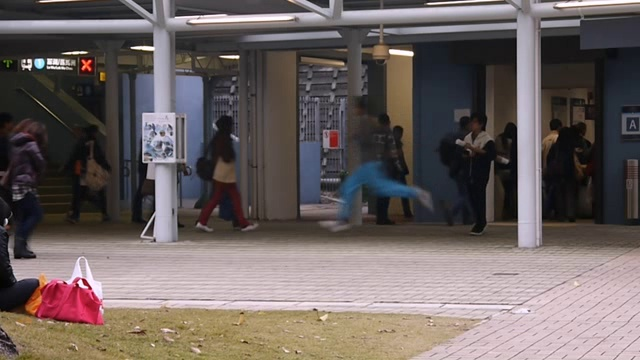

In [22]:
image.show()

In [24]:
# %%timeit -n 100
# # benchmark
# with torch.no_grad():
#     # Run the model on the batch
#     outputs = model(pixel_values=batch_images)

In [17]:
%%capture
# results = model.predict(image, conf=0.7, agnostic_nms=False, max_det=20, iou=0.45, imgsz=(640, 360))
results = model.predict(
    image,
    conf=0.35,
    agnostic_nms=False,
    max_det=30,
    iou=0.45,
    imgsz=(640, 360),
    retina_masks=True,
)


WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 224x384 7 persons, 1 handbag, 126.5ms
Speed: 1.3ms preprocess, 126.5ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 384)


In [18]:
# observe results
print(results[0].boxes.xyxy.int().tolist())
render = render_result(model=model, image=image, result=results[0])
render.show()

[[193, 115, 258, 233], [456, 112, 496, 235], [0, 121, 46, 258], [63, 121, 112, 224], [0, 194, 41, 311], [34, 276, 105, 325], [319, 97, 433, 232], [541, 117, 562, 219]]


In [11]:
render.size

(640, 360)

In [12]:
boxes_list = results[0].boxes.xyxy.int().tolist()
print(boxes_list)

[[402, 100, 446, 235], [442, 105, 488, 236], [223, 113, 274, 231], [300, 115, 361, 230], [195, 118, 232, 232], [624, 127, 639, 235], [273, 120, 307, 221]]


In [13]:
image.size

(640, 360)

#### Avenue Example

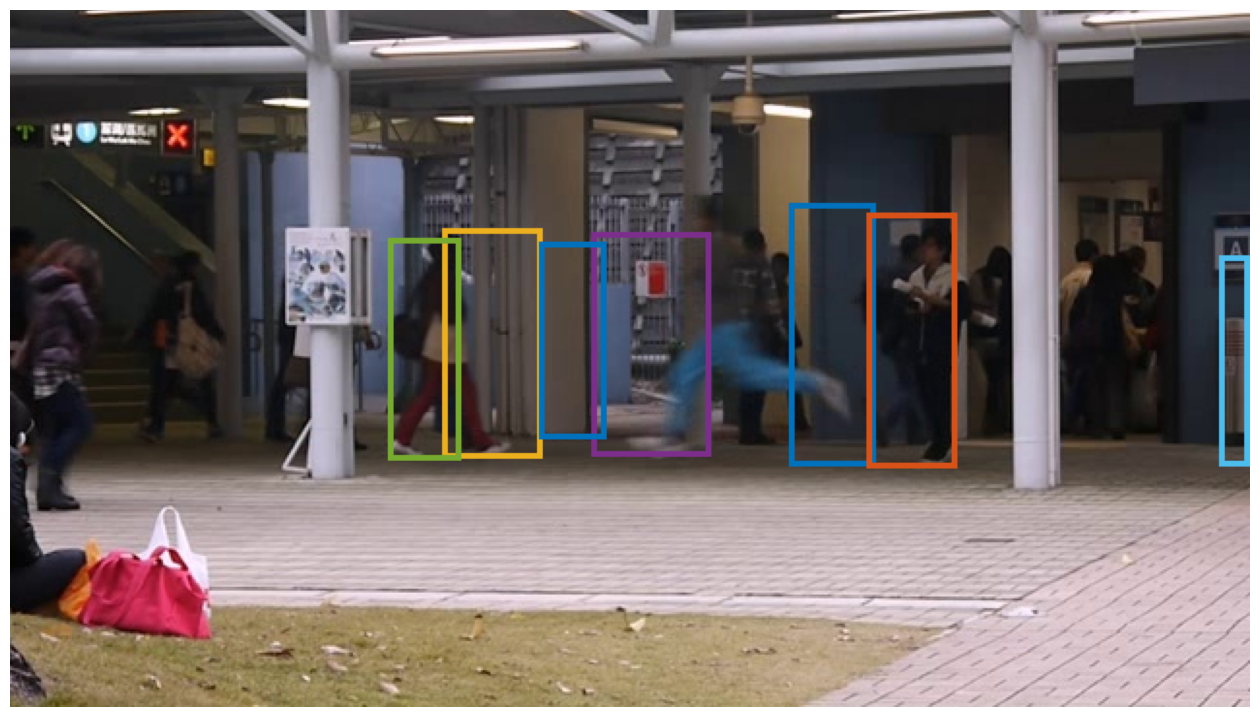

In [19]:
%matplotlib inline
# This function can now also create images with bounding boxes and the cropped objects and save them to a location
_, cropped_objects = plot_results_avenue(
    image,
    0.5,
    boxes_list,
    im_size=(640, 360),
    display_img=True,
    save_path=None,
    crop_objects=True,
)


WARNING ⚠️ imgsz=[640, 360] must be multiple of max stride 32, updating to [640, 384]
0: 256x384 (no detections), 163.9ms
Speed: 1.1ms preprocess, 163.9ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 384)
[]


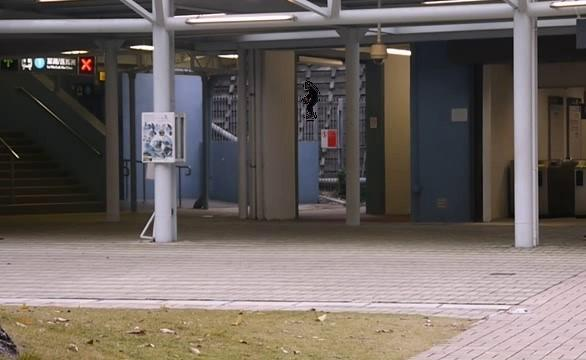

In [23]:
%matplotlib inline
image_tensor, image = preprocess(
    "./datasets/UBNormal/train_anomalies_avenue_background_frames/abnormal_scene_9_scenario_1/abnormal_scene_9_scenario_1_0253_1.jpg",
    transform=transform,
)
results = model.predict(
    image,
    conf=0.35,
    agnostic_nms=False,
    max_det=30,
    iou=0.45,
    imgsz=(640, 360),
    retina_masks=True,
)
print(results[0].boxes.xyxy.int().tolist())
render = render_result(model=model, image=image, result=results[0])
render.show()
# _, cropped_objects = plot_results_avenue(image, 0.5, boxes_list, im_size=(640, 360), display_img=True, save_path=None, crop_objects=True)

#### Shanghaitech Example

In [15]:
image_tensor, image = preprocess(
    "./datasets/shanghaitech/testing/frames/02_0128/347.jpg", transform=transform
)

In [16]:
results = model.predict(
    image,
    conf=0.35,
    agnostic_nms=False,
    max_det=30,
    iou=0.3,
    imgsz=(856, 480),
    retina_masks=True,
)


WARNING ⚠️ imgsz=[856, 480] must be multiple of max stride 32, updating to [864, 480]
0: 288x480 6 persons, 1 bicycle, 1 car, 296.7ms
Speed: 1.5ms preprocess, 296.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 480)


[[342, 83, 406, 231], [617, 48, 662, 141], [793, 57, 823, 129], [136, 43, 176, 142], [806, 17, 839, 39], [779, 18, 798, 74], [787, 100, 807, 137], [800, 30, 818, 65]]


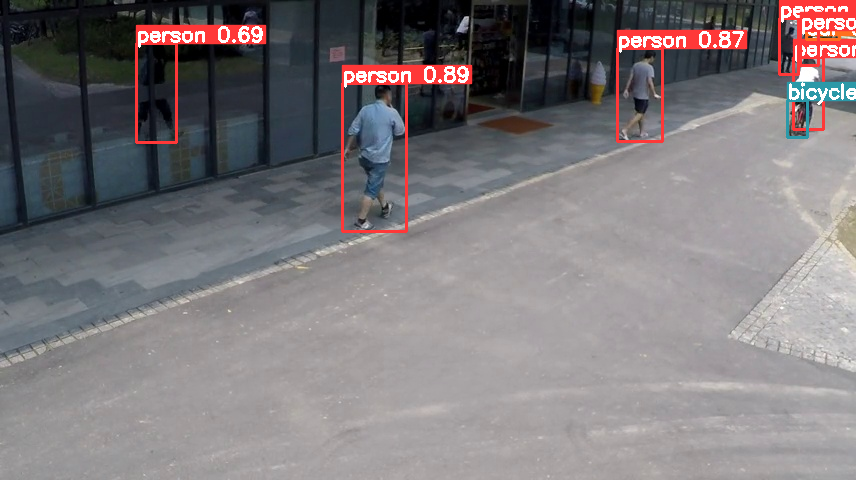

In [17]:
print(results[0].boxes.xyxy.int().tolist())
render = render_result(model=model, image=image, result=results[0])
render.show()

In [19]:
print(render.size, image.size)

(856, 480) (856, 480)


In [20]:
boxes_list = results[0].boxes.xyxy.int().tolist()
print(boxes_list)

[[343, 82, 406, 231], [617, 48, 663, 141], [793, 57, 824, 129], [136, 42, 177, 142], [806, 16, 840, 38], [780, 18, 799, 74], [787, 100, 808, 137], [800, 29, 819, 64]]


#### UBNormal Example

In [20]:
image_tensor, image = preprocess(
    "./datasets/UBNormal/train_normal_frames/normal_scene_2_scenario_1/normal_scene_2_scenario_1_0148.jpg",
    transform=transform,
)

In [21]:
results = model.predict(
    image,
    conf=0.65,
    agnostic_nms=False,
    max_det=30,
    iou=0.3,
    imgsz=(856, 480),
    retina_masks=True,
)


WARNING ⚠️ imgsz=[856, 480] must be multiple of max stride 32, updating to [864, 480]
0: 288x480 3 persons, 39.3ms
Speed: 1.0ms preprocess, 39.3ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 480)


[[164, 313, 201, 407], [1095, 311, 1133, 412], [1002, 319, 1031, 401]]


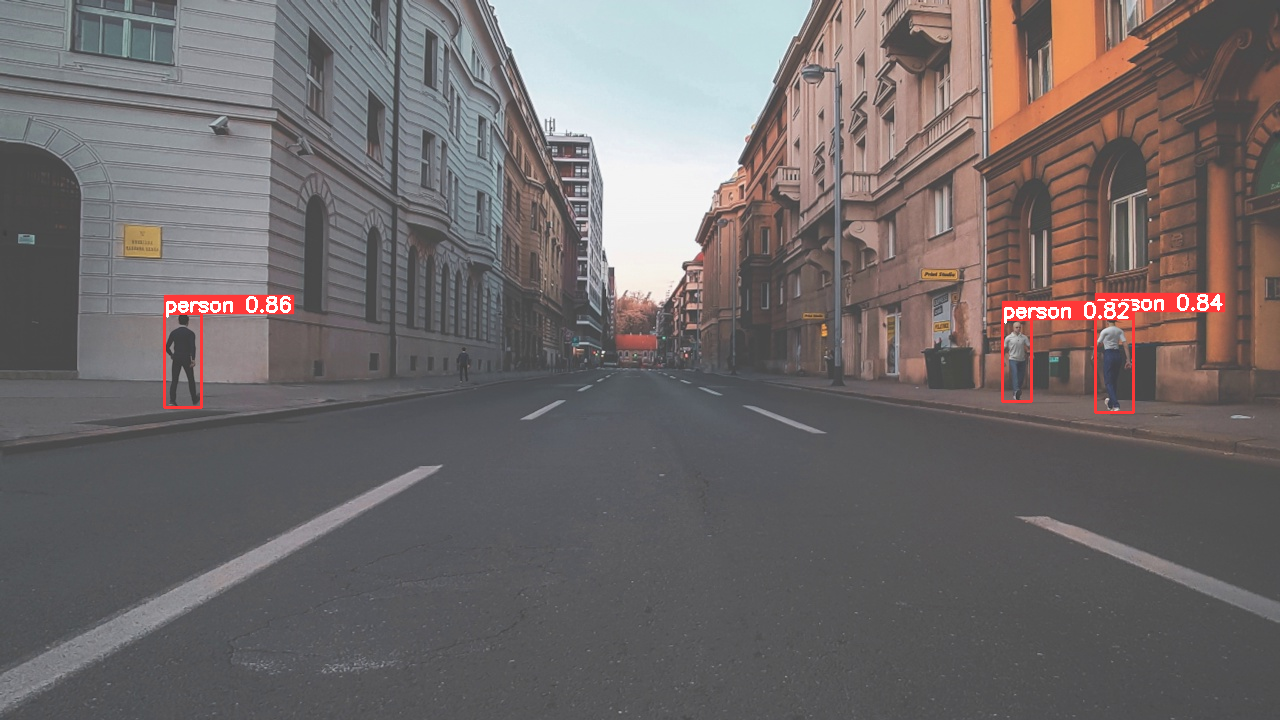

In [22]:
print(results[0].boxes.xyxy.int().tolist())
render = render_result(model=model, image=image, result=results[0])
render.show()

## Avenue Prediction using YoloV8

In [17]:
train_dir = "./datasets/Avenue Dataset/train__/"
train_video_dirs = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
]
train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir, dir)
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/train__/01 1364
./datasets/Avenue Dataset/train__/02 1511
./datasets/Avenue Dataset/train__/03 1487
./datasets/Avenue Dataset/train__/04 1511
./datasets/Avenue Dataset/train__/05 815
./datasets/Avenue Dataset/train__/06 1511
./datasets/Avenue Dataset/train__/07 1099
./datasets/Avenue Dataset/train__/08 1017
./datasets/Avenue Dataset/train__/09 1391
./datasets/Avenue Dataset/train__/10 1223
./datasets/Avenue Dataset/train__/11 781
./datasets/Avenue Dataset/train__/12 145
./datasets/Avenue Dataset/train__/13 366
./datasets/Avenue Dataset/train__/14 510
./datasets/Avenue Dataset/train__/15 353
./datasets/Avenue Dataset/train__/16 244
Total Frames: 15328


In [18]:
test_dir = "./datasets/Avenue Dataset/test__/"
test_video_dirs = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21",
]
test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")

./datasets/Avenue Dataset/test__/01 1439
./datasets/Avenue Dataset/test__/02 1211
./datasets/Avenue Dataset/test__/03 923
./datasets/Avenue Dataset/test__/04 947
./datasets/Avenue Dataset/test__/05 1007
./datasets/Avenue Dataset/test__/06 1283
./datasets/Avenue Dataset/test__/07 605
./datasets/Avenue Dataset/test__/08 36
./datasets/Avenue Dataset/test__/09 1175
./datasets/Avenue Dataset/test__/10 841
./datasets/Avenue Dataset/test__/11 472
./datasets/Avenue Dataset/test__/12 1271
./datasets/Avenue Dataset/test__/13 549
./datasets/Avenue Dataset/test__/14 507
./datasets/Avenue Dataset/test__/15 1001
./datasets/Avenue Dataset/test__/16 740
./datasets/Avenue Dataset/test__/17 426
./datasets/Avenue Dataset/test__/18 294
./datasets/Avenue Dataset/test__/19 248
./datasets/Avenue Dataset/test__/20 273
./datasets/Avenue Dataset/test__/21 76
Total Frames: 15324


In [19]:
preds_path = "./datasets/Avenue Dataset/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
print(train_preds_path, test_preds_path)

./datasets/Avenue Dataset/predictions/train/ ./datasets/Avenue Dataset/predictions/test/


In [20]:
objects_path = "./datasets/Avenue Dataset/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
print(train_objects_path, test_objects_path)

./datasets/Avenue Dataset/objects/train/ ./datasets/Avenue Dataset/objects/test/


In [21]:
image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names)

['00.jpg', '01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg']


### Generate Train Objects and predictions

In [ ]:
%%capture
im_size = (640, 360)

transform = T.Compose([T.Resize(im_size), T.ToTensor(), T.Normalize(0.5, 0.5)])
bbox_temp = {}
video_names = [video.split("/")[-1] for video in train_video_paths]
print(video_names)
# obj_det_dict = {}

for i, video_path in enumerate(train_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(train_video_paths[i])]

    frame_idx = 0
    for image_name in image_names:
        full_image_path = os.path.join(train_video_paths[i], image_name)

        image_tensor, image = preprocess(full_image_path, transform=transform)

        # probab, boxes = detect(image, model)
        with torch.no_grad():
            results = model.predict(
                image, agnostic_nms=False, max_det=30, iou=0.3, imgsz=im_size
            )

        # # Process boxes and convert to Python lists with integers
        # boxes_list = []
        # for box in boxes:
        #     int_box = [int(elem.item()) for elem in box]  # Convert each element to an int and then to a Python list
        #     boxes_list.append(int_box)

        boxes_list = results[0].boxes.xyxy.int().tolist()

        # TODO: Save this dict
        bbox_temp[frame_idx] = boxes_list

        frame_idx += 1

        image_prediction_path = os.path.join(
            train_preds_path, test_video_dirs[i], image_name
        )
        # print(image_prediction_path)

        # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        _, cropped_objects = plot_results_avenue(
            image,
            0.5,
            boxes_list,
            im_size=im_size,
            display_img=False,
            save_path=image_prediction_path,
            crop_objects=True,
        )

        objects_prediction_path = os.path.join(train_objects_path, test_video_dirs[i])

        save_cropped_images(
            cropped_objects,
            objects_prediction_path,
            image_prefix=image_name.split(".")[0],
        )

    # obj_det_dict[video_names[i]] = bbox_temp

### Generate Test objects and predictions

In [ ]:
%%capture
im_size = (640, 360)

# %matplotlib inline
transform = T.Compose([T.Resize(im_size), T.ToTensor(), T.Normalize(0.5, 0.5)])
bbox_temp = {}
video_names = [video.split("/")[-1] for video in test_video_paths]
print(video_names)
obj_det_dict = {}

for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[i])]

    bbox_temp = {}

    for frame_idx, image_name in enumerate(image_names):
        # print(f"------------Frame: {frame_idx}-----------")
        full_image_path = os.path.join(test_video_paths[i], image_name)
        # print(f"{full_image_path}")

        # image_tensor, image = preprocess(full_image_path, transform=transform)

        # # Prepare the plot for this frame
        # fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        # ax[0].imshow(image)
        # ax[0].set_title("Original Frame")

        # frame_anomaly_map = np.zeros(image.size[::-1])

        # probab, boxes = detect(image, model)
        with torch.no_grad():
            results = model.predict(
                full_image_path,
                conf=0.85,
                agnostic_nms=False,
                max_det=30,
                iou=0.45,
                imgsz=im_size,
            )

        # # Process boxes and convert to Python lists with integers
        # boxes_list = []
        # for box in boxes:
        #     int_box = [int(elem.item()) for elem in box]  # Convert each element to an int and then to a Python list
        #     boxes_list.append(int_box)

        boxes_list = results[0].boxes.xyxy.int().tolist()

        # for bbox_idx, bbox in enumerate(boxes_list):
        #     cropped_obj = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
        #     # Plot cropped object
        #     ax[1].imshow(cropped_obj)
        #     ax[1].set_title(f"Cropped Object {bbox_idx+1}")

        #     # Add anomaly map rectangle to the original frame
        #     rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        #     ax[0].add_patch(rect)

        # Display the frame anomaly map
        # ax[3].imshow(frame_anomaly_map, cmap='hot', interpolation='nearest')
        # ax[3].set_title("Frame Anomaly Map")

        # For every frame of a video, we will store a list containing [xmin, ymin, xmax, ymax] for every detected object
        bbox_temp[frame_idx] = boxes_list

        # image_prediction_path = os.path.join(test_preds_path, test_video_dirs[i], image_name)
        # # print(image_prediction_path)

        # # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        # _, cropped_objects = plot_results_avenue(image, 0.5, boxes_list, im_size=im_size, display_img=False, save_path=image_prediction_path, crop_objects=True)

        # objects_prediction_path = os.path.join(test_objects_path, test_video_dirs[i])

        # save_cropped_images(cropped_objects, objects_prediction_path, image_prefix=image_name.split('.')[0])

    obj_det_dict[video_names[i]] = bbox_temp

### Debugging

In [ ]:
# Save the object to a file
with open("obj_dect_avenue_yolov8_conf_084", "wb") as file:
    pickle.dump(obj_det_dict, file)

In [ ]:
# Read obj_det_avenue_test
with open("obj_dect_avenue_yolov8_conf_0.35", "rb") as file:
    obj_dect_avenue = pickle.load(file)

In [27]:
# obj_dect_avenue

## Shanghaitech Prediction using YoloV8

In [21]:
def get_directory_names(parent_directory):
    directory_names = [
        d
        for d in os.listdir(parent_directory)
        if os.path.isdir(os.path.join(parent_directory, d))
    ]
    return directory_names

#### Train Path

In [ ]:
train_dir = "./datasets/shanghaitech/training/frames/"

# Example usage
train_video_dirs = get_directory_names(train_dir)
print(train_video_dirs[:5])

train_video_paths = []
total_frames = 0
for dir in train_video_dirs:
    cur_dir = os.path.join(train_dir, dir)
    train_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")  # 274515

#### Test Path

In [ ]:
test_dir = "./datasets/shanghaitech/testing/frames/"

# Example usage
test_video_dirs = get_directory_names(test_dir)
print(test_video_dirs[:5])

test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(f"Total Frames: {total_frames}")  # 40791

#### Prediction Path

In [24]:
preds_path = "./datasets/shanghaitech/predictions/"
train_preds_path = os.path.join(preds_path, "train/")
test_preds_path = os.path.join(preds_path, "test/")
# create_directories(train_preds_path, train_video_dirs)

#### Objects Path

In [25]:
objects_path = "./datasets/shanghaitech/objects/"
train_objects_path = os.path.join(objects_path, "train/")
test_objects_path = os.path.join(objects_path, "test/")
# create_directories(train_objects_path, train_video_dirs)

In [26]:
image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[-1])]
print(image_names[:5])

['000.jpg', '001.jpg', '002.jpg', '003.jpg', '004.jpg']


## UBnormal Prediction using YoloV8

In [17]:
def get_directory_names(parent_directory):
    directory_names = [
        d
        for d in os.listdir(parent_directory)
        if os.path.isdir(os.path.join(parent_directory, d))
    ]
    return directory_names

#### Train Path

In [18]:
# train_dir = "./datasets/UBNormal/train_normal_frames/"

# # Example usage
# train_video_dirs = get_directory_names(train_dir)
# print(train_video_dirs[:5])

# train_video_paths = []
# total_frames = 0
# for dir in train_video_dirs:
#     cur_dir = os.path.join(train_dir, dir)
#     train_video_paths.append(cur_dir)
#     jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
#     total_frames += len(jpg_files)
#     print(cur_dir, len(jpg_files))
# print(len(train_video_dirs))  # 186
# print(f"Total Frames: {total_frames}") # 79503

In [ ]:
train_ab_dir = "./datasets/UBNormal/train_anomalies_avenue_background_frames/"

# Example usage
train_ab_video_dirs = get_directory_names(train_ab_dir)
print(train_ab_video_dirs[:5])

train_ab_video_paths = []
total_frames = 0
for dir in train_ab_video_dirs:
    cur_dir = os.path.join(train_ab_dir, dir)
    train_ab_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))
print(len(train_ab_video_dirs))  # 186
print(f"Total Frames: {total_frames}")  # 79503

#### Take test normal + test abnormal

In [ ]:
test_dir = "./datasets/UBNormal/test/"
normal_test_dir = os.path.join(test_dir, "test_normal_frames/")
abnormal_test_dir = os.path.join(test_dir, "test_abnormal_frames/")

test_video_dirs = get_directory_names(normal_test_dir)
ab_test_dirs = get_directory_names(abnormal_test_dir)


# test_video_paths = []
# total_frames = 0
# for dir in test_video_dirs:
#     cur_dir = os.path.join(test_dir, dir)
#     test_video_paths.append(cur_dir)
#     jpg_files = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
#     total_frames += len(jpg_files)
#     print(cur_dir, len(jpg_files))

test_video_paths = []
total_frames = 0
for dir in test_video_dirs:
    cur_dir = os.path.join(normal_test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))

for dir in ab_test_dirs:
    cur_dir = os.path.join(abnormal_test_dir, dir)
    test_video_paths.append(cur_dir)
    jpg_files = [f for f in os.listdir(cur_dir) if f.endswith(".jpg")]
    total_frames += len(jpg_files)
    print(cur_dir, len(jpg_files))

test_video_dirs.extend(ab_test_dirs)

print(len(test_video_paths))  # 211
print(f"Total Frames: {total_frames}")  # 92640
video_names = test_video_dirs

In [25]:
preds_path = "./datasets/UBNormal/"
# train_preds_path = os.path.join(preds_path, "train_normal_predictions/")
train_preds_path = os.path.join(preds_path, "train_anomalies_avenue_background_preds/")
# test_preds_path = os.path.join(preds_path, "test/predictions/")
# create_directories(train_preds_path, train_video_dirs)

In [26]:
objects_path = "./datasets/UBNormal/"
train_objects_path = os.path.join(
    objects_path, "train_anomalies_avenue_background_objects/"
)
# test_objects_path = os.path.join(objects_path, "test_normal_objects/")
# create_directories(train_objects_path, train_video_dirs)

### Generate Objects and Predictions for Train

#### Normal Objects

In [23]:
%%capture
# For UBNormal, we don't use im_size as we have images of varying sizes
# im_size = (1080, 720)

transform = T.Compose(
    [
        # T.Resize(im_size),
        T.ToTensor(),
        T.Normalize(0.5, 0.5),
    ]
)
bbox_temp = {}
video_names = [video.split("/")[-1] for video in train_ab_video_paths]
print(video_names)
# obj_det_dict = {}

for i, video_path in enumerate(sorted(train_ab_video_paths)):
    print(video_path)
    image_names = [
        img.split("/")[-1] for img in list_image_files(train_ab_video_paths[i])
    ]

    for frame_idx, image_name in enumerate(image_names):
        full_image_path = os.path.join(train_ab_video_paths[i], image_name)

        # image_tensor, image = preprocess(full_image_path, transform=transform)
        image = Image.open(full_image_path)
        im_size = (image.size[0], image.size[1])

        # probab, boxes = detect(image, model)
        with torch.no_grad():
            results = model.predict(
                full_image_path,
                conf=0.65,
                agnostic_nms=False,
                max_det=30,
                iou=0.45,
                imgsz=im_size,
            )

        # # Process boxes and convert to Python lists with integers
        # boxes_list = []
        # for box in boxes:
        #     int_box = [int(elem.item()) for elem in box]  # Convert each element to an int and then to a Python list
        #     boxes_list.append(int_box)

        boxes_list = results[0].boxes.xyxy.int().tolist()

        # TODO: Save this dict
        bbox_temp[frame_idx] = boxes_list

        image_prediction_path = os.path.join(
            train_preds_path, train_video_dirs[i], image_name
        )
        # print(image_prediction_path)

        # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        _, cropped_objects = plot_results_avenue(
            image,
            0.5,
            boxes_list,
            im_size=im_size,
            display_img=False,
            save_path=image_prediction_path,
            crop_objects=True,
        )

        objects_prediction_path = os.path.join(train_objects_path, train_video_dirs[i])

        save_cropped_images(
            cropped_objects,
            objects_prediction_path,
            image_prefix=image_name.split(".")[0],
        )

    # obj_det_dict[video_names[i]] = bbox_temp


WARNING ⚠️ imgsz=[586, 360] must be multiple of max stride 32, updating to [608, 384]
image 1/1 /mnt/c/Users/Sergiu/Desktop/AnomalyDetection/datasets/UBNormal/train_anomalies_avenue_background_frames/abnormal_scene_11_scenario_3/abnormal_scene_11_scenario_3_0317_1.jpg: 256x384 1 person, 92.0ms
Speed: 1.3ms preprocess, 92.0ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 384)


NameError: name 'train_preds_path' is not defined

#### Abnormal Objects

In [ ]:
%%capture
# For UBNormal, we don't use im_size as we have images of varying sizes
# im_size = (1080, 720)

# transform = T.Compose([
#     T.Resize(im_size),
#     T.ToTensor(),
#     T.Normalize(0.5, 0.5)
# ])
bbox_temp = {}
video_names = [video.split("/")[-1] for video in train_ab_video_paths]
print(video_names)
# obj_det_dict = {}

for i, video_path in enumerate(sorted(train_ab_video_paths)):
    print(video_path)
    image_names = [
        img.split("/")[-1] for img in list_image_files(train_ab_video_paths[i])
    ]

    for frame_idx, image_name in enumerate(image_names):
        full_image_path = os.path.join(train_ab_video_paths[i], image_name)

        # image_tensor, image = preprocess(full_image_path, transform=transform)
        image = Image.open(full_image_path)
        im_size = (image.size[0], image.size[1])

        # probab, boxes = detect(image, model)
        with torch.no_grad():
            results = model.predict(
                full_image_path,
                conf=0.65,
                agnostic_nms=False,
                max_det=30,
                iou=0.45,
                imgsz=im_size,
            )

        # # Process boxes and convert to Python lists with integers
        # boxes_list = []
        # for box in boxes:
        #     int_box = [int(elem.item()) for elem in box]  # Convert each element to an int and then to a Python list
        #     boxes_list.append(int_box)

        boxes_list = results[0].boxes.xyxy.int().tolist()

        # TODO: Save this dict
        bbox_temp[frame_idx] = boxes_list

        image_prediction_path = os.path.join(
            train_preds_path, train_ab_video_dirs[i], image_name
        )
        # print(image_prediction_path)

        # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        _, cropped_objects = plot_results_avenue(
            image,
            0.5,
            boxes_list,
            im_size=im_size,
            display_img=False,
            save_path=image_prediction_path,
            crop_objects=True,
        )

        objects_prediction_path = os.path.join(
            train_objects_path, train_ab_video_dirs[i]
        )

        save_cropped_images(
            cropped_objects,
            objects_prediction_path,
            image_prefix=image_name.split(".")[0],
        )

    # obj_det_dict[video_names[i]] = bbox_temp

### Generate Objects and Predictions for Test

In [ ]:
%%capture
# im_size = (856, 480)
# im_size =

# %matplotlib inline
# transform = T.Compose([
#     T.Resize(im_size),
#     T.ToTensor(),
#     T.Normalize(0.5, 0.5)
# ])
bbox_temp = {}
video_names = [video.split("/")[-1] for video in test_video_paths]
print(video_names)
obj_det_dict = {}

for i, video_path in enumerate(test_video_paths):
    print(video_path)
    image_names = [img.split("/")[-1] for img in list_image_files(test_video_paths[i])]

    bbox_temp = {}

    for frame_idx, image_name in enumerate(image_names):
        # print(f"------------Frame: {frame_idx}-----------")
        full_image_path = os.path.join(test_video_paths[i], image_name)

        # image_tensor, image = preprocess(full_image_path, transform=transform)
        image = Image.open(full_image_path)
        im_size = (image.size[0], image.size[1])

        # probab, boxes = detect(image, model)
        with torch.no_grad():
            results = model.predict(
                full_image_path,
                conf=0.82,
                agnostic_nms=False,
                max_det=30,
                iou=0.45,
                imgsz=im_size,
            )

        boxes_list = results[0].boxes.xyxy.int().tolist()

        # for bbox_idx, bbox in enumerate(boxes_list):
        #     cropped_obj = image.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
        #     # Plot cropped object
        #     ax[1].imshow(cropped_obj)
        #     ax[1].set_title(f"Cropped Object {bbox_idx+1}")

        #     # Add anomaly map rectangle to the original frame
        #     rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
        #     ax[0].add_patch(rect)

        # Display the frame anomaly map
        # ax[3].imshow(frame_anomaly_map, cmap='hot', interpolation='nearest')
        # ax[3].set_title("Frame Anomaly Map")

        # For every frame of a video, we will store a list containing [xmin, ymin, xmax, ymax] for every detected object
        bbox_temp[frame_idx] = boxes_list

        # image_prediction_path = os.path.join(test_preds_path, test_video_dirs[i], image_name)
        # print(image_prediction_path)

        # This function can now also create images with bounding boxes and the cropped objects and save them to a location
        # _, cropped_objects = plot_results_avenue(image, 0.5, boxes_list, im_size=im_size, display_img=False, save_path=image_prediction_path, crop_objects=True)

        # objects_prediction_path = os.path.join(test_objects_path, test_video_dirs[i])

        # save_cropped_images(cropped_objects, objects_prediction_path, image_prefix=image_name.split('.')[0])

    obj_det_dict[video_names[i]] = bbox_temp

In [ ]:
# Save the object to a file
with open("obj_dect_ubnormal_yolov8_conf_08", "wb") as file:
    pickle.dump(obj_det_dict, file)

# End of Notebook